**Exercícios Rotulação de Componentes Conexos**
exercícios obtidos em http://homepages.inf.ed.ac.uk/rbf/HIPR2/label.htm


1. Implemente o algoritmo de rotulação de componentes conexos (algoritmo do slide ou por outra solução) e aplique sobre a imagem binária art8.png. Indique qual vizinhança será considerada (4 ou 8)
Mostre os resultados na forma da imagem art8lab1.png e art8lab2.png

art8.png: 
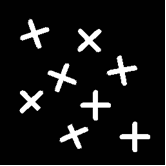
art8lab1.png: 
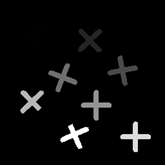
art8lab2.png: 
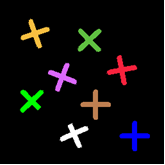
		

In [9]:
# code here
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import logging
from os import path

def getLocalTime():
    named_tuple = time.localtime() # get struct_time
    return time.strftime("%d/%m/%Y, %H:%M:%S", named_tuple)

class GrayImageComponentIdentifier:
    def __init__(self, path, debug = False) -> None:
        self.path = path
        self.debug = debug
        self.result = None
        self.image = None
    
    def __logImageSize(self):
        self.__log('Tamanho da imagem', self.image.shape)

    def __log(self, content, *args):
        print('[%s] %s: ' % (getLocalTime(), content), *args)

    def disableDebug(self):
        self.debug = False

    def enableDebug(self):
        self.debug = True

    def setPath(self, path) -> None:
        self.path = path

    def getImage(self):
        image = cv2.imread(self.path, cv2.IMREAD_GRAYSCALE)

        if not path.isfile(self.path):
            raise TypeError('O caminho não corresponde a um arquivo')

        if image is None:
            raise TypeError('O caminho não corresponde a uma imagem')
        
        return image

    def show(self, mode = 'sync') -> None:
        if self.image == None:
            self.image = self.getImage()
            
            if self.debug:
                self.__logImageSize()
            
        self.showImage(self.image, mode)

    def identifyComponents(self):
        labeledImage = np.zeros(self.image.shape)
        self.componentsNum = self.labeler(labeledImage, 1)

        self.result = labeledImage * 255 / self.componentsNum
        print(self.result)

    def labeler(self, labeledImage, label):
        height, width = self.image.shape
        neighbors = []
        point = current = {}
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                point = { 'x': i, 'y': j }

                if self.ableToLabel(self.image, labeledImage, point):
                    labeledImage[i][j] = label

                    # Empilha o ponto atual da imagem
                    neighbors.append(point)
                    while len(neighbors) > 0:
                        # desempilha os visinhos
                        current = neighbors.pop()

                        point = {
                            'x': current['x'] - 1,
                            'y': current['y']
                        }

                        # procura por vizinhos acima que respeitam a condição Q
                        self.findNeighbors(labeledImage, point, neighbors, label)

                        point = {
                            'x': current['x'] + 1,
                            'y': current['y'],
                        }

                        # procura por vizinhos abaixo que respeitam a condição Q
                        self.findNeighbors(labeledImage, point, neighbors, label)

                        point = {
                            'x': current['x'],
                            'y': current['y'] - 1,
                        }

                        # procura por vizinhos a esquerda que respeitam a condição Q
                        self.findNeighbors(labeledImage, point, neighbors, label)

                        point = {
                            'x': current['x'],
                            'y': current['y'] + 1,
                        }

                        # procura por vizinhos a direita que respeitam a condição Q
                        self.findNeighbors(labeledImage, point, neighbors, label)
                    label += 1

        return label


    def findNeighbors(self, labeledImage, point, neighbors, label):
        if self.ableToLabel(self.image, labeledImage, point):
            labeledImage[point['x']][point['y']] = label
            neighbors.append(point)

    def colorCriterion(self, image, point):
        height, width = image.shape
        return point['x'] >= 0 \
            and point['y'] >= 0 \
            and point['x'] < height \
            and point['y'] < width \
            and image[point['x']][point['y']] == 255

    def unlabeled(self, labeledImage, point):
        return labeledImage[point['x']][point['y']] == 0

    def ableToLabel(self, image, labeledImage, point):
        return self.colorCriterion(image, point) and self.unlabeled(labeledImage, point)
    
    def showImage(self, image, mode = 'sync', gray = True) -> None:
        ax = plt.subplots()[1]

        if gray:
            ax.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
        else:
            ax.imshow(image, vmin = 0, vmax = 255)

        if self.debug:
            self.__log('ploting image ...')
            
        if mode == 'sync':
            plt.show()

    def showResult(self, mode = 'sync') -> None:
        self.validateResult()
        self.showImage(self.result, mode)

    def showColoredResult(self, mode = 'sync') -> None:
        self.validateResult()
        self.showImage(self.result, mode, gray=False)

    def saveResult(self, filename = 'result', mode = 'sync') -> None:
        self.validateResult()
        
        ax = plt.subplots()[1]
        ax.imshow(self.result, cmap = 'gray', vmin = 0, vmax = 255)

        if self.debug:
            self.__log('saving image ...')

        plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

        if mode == 'sync':
            plt.show()

    def validateResult(self):
        if self.result is None:
            raise ValueError('O resultado não pode ser nulo')

[25/03/2023, 07:59:51] Tamanho da imagem:  (256, 256)
[25/03/2023, 07:59:51] ploting image ...: 


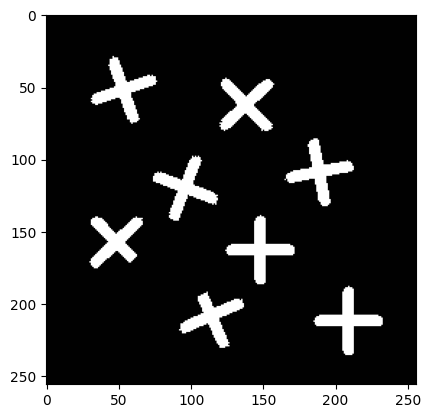

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[25/03/2023, 07:59:53] ploting image ...: 


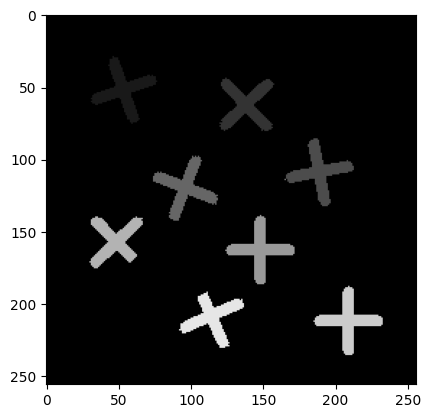

[25/03/2023, 07:59:53] ploting image ...: 


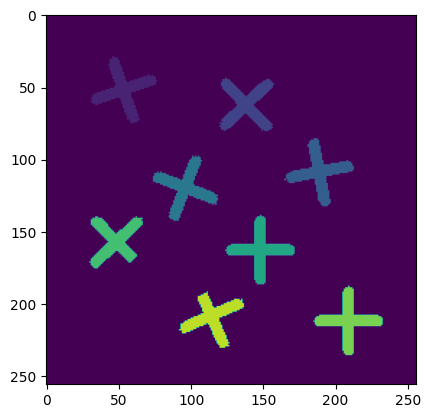

In [10]:
def main():
    image = GrayImageComponentIdentifier(path='art8.png', debug=True)

    image.show()
    image.identifyComponents()

    image.showResult()
    image.showColoredResult()

main()

2. Calcule o número de objetos da imagem clc3.png. Note que antes será necessário binarizar a imagem. Para isso, considere um limiar (*threshold*) de 67, isto é, valores acima de 67 na imagem original recebem zero, e os abaixo recebem 1 (o que resulta na imagem clc3thr1.png).

clc3.png
![clc3.png](clc3.png)
clc3thr1
![clc3thr1.png](clc3thr1.png)
clc3lab1
![clc3lab1.png](clc3lab1.png)
		

In [ ]:
# code here